In [2]:
# Install required package
!pip install simpy

# Imports
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import simpy
from sklearn.linear_model import LinearRegression

# Reproducibility
random.seed(42)
np.random.seed(42)

# Create folders for data and results
os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)


In [3]:
# Define study window (10am – 8pm)
START = datetime(2025, 3, 5, 10, 0, 0)
END   = datetime(2025, 3, 5, 20, 0, 0)
minutes = int((END - START).total_seconds() // 60)

# Demand rate function (two peaks: lunch & evening)
def demand_rate_by_minute(m):
    hour = (START + timedelta(minutes=m)).hour + (START + timedelta(minutes=m)).minute/60
    base = 0.6
    lunch_amp = 0.9 * np.exp(-((hour - 13)/0.9)**2)
    eve_amp   = 0.8 * np.exp(-((hour - 18)/0.9)**2)
    return max(0.05, base + lunch_amp + eve_amp)

# Generate arrivals
arrivals = []
cid = 1
for m in range(minutes):
    k = np.random.poisson(demand_rate_by_minute(m))
    for _ in range(k):
        t = START + timedelta(minutes=m, seconds=np.random.randint(0,60))
        is_return = np.random.rand() < 0.45
        has_fine  = is_return and (np.random.rand() < 0.15)
        arrivals.append({
            "txn_id": cid,
            "timestamp": t,
            "type": "return" if is_return else "borrow",
            "fine": int(has_fine)
        })
        cid += 1

df = pd.DataFrame(arrivals).sort_values("timestamp").reset_index(drop=True)

# Assign service times
def draw_service_seconds(row):
    if row.type == "borrow":
        return int(np.random.normal(150, 30))      # ~2.5 min
    elif row.fine == 1:
        return int(np.random.normal(270, 60))      # ~4.5 min
    else:
        return int(np.random.normal(90, 20))       # ~1.5 min

df["service_seconds"] = df.apply(draw_service_seconds, axis=1)
df.to_csv("data/borrow_return_logs.csv", index=False)

print(f"Generated {len(df)} transactions")
df.head()


Generated 547 transactions


,txn_id,timestamp,type,fine,service_seconds
0,2,2025-03-05 10:01:10,borrow,0,152
1,1,2025-03-05 10:01:38,return,1,235
2,3,2025-03-05 10:02:21,return,0,106
3,4,2025-03-05 10:03:59,return,0,78
4,5,2025-03-05 10:07:27,borrow,0,169


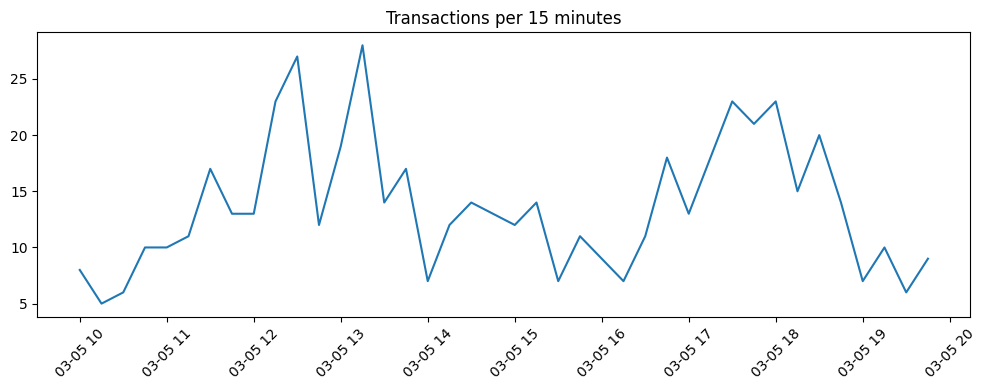

Service Time Summary:


count        mean        std    min    25%    50%     75%    max
type   fine                                                                  
borrow 0     310.0  152.206452  31.170727   62.0  130.0  154.0  173.00  247.0
return 0     192.0   89.901042  20.348421   39.0   76.0   89.0  104.25  142.0
       1      45.0  274.155556  59.137342  132.0  235.0  276.0  297.00  407.0

In [4]:
# Transactions per 15 minutes
df['t15'] = df['timestamp'].dt.floor('15min')
throughput = df.groupby('t15').size().reset_index(name="transactions")

# Service time summary
svc_summary = df.groupby(['type','fine'])['service_seconds'].describe()

# Plot throughput
plt.figure(figsize=(10,4))
plt.plot(throughput['t15'], throughput['transactions'])
plt.title("Transactions per 15 minutes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Service Time Summary:")
svc_summary


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


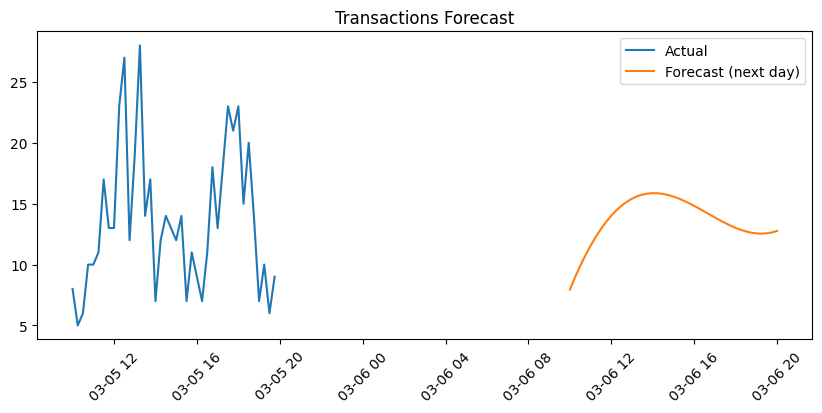

In [5]:
tp = throughput.copy()
tp['hour'] = tp['t15'].dt.hour + tp['t15'].dt.minute/60.0
tp['sin'] = np.sin(2*np.pi*tp['hour']/24)
tp['cos'] = np.cos(2*np.pi*tp['hour']/24)

X = tp[['hour','sin','cos']]
y = tp['transactions']
model = LinearRegression().fit(X, y)

# Forecast for next day
future_times = pd.date_range(START + timedelta(days=1), END + timedelta(days=1), freq="15min")
fhour = future_times.hour + future_times.minute/60.0
fX = np.column_stack([fhour, np.sin(2*np.pi*fhour/24), np.cos(2*np.pi*fhour/24)])
yhat = model.predict(fX)

plt.figure(figsize=(10,4))
plt.plot(tp['t15'], tp['transactions'], label="Actual")
plt.plot(future_times, yhat, label="Forecast (next day)")
plt.legend()
plt.title("Transactions Forecast")
plt.xticks(rotation=45)
plt.show()


In [6]:
SIM_END_SEC = minutes * 60

def per_second_lambda(sec):
    return demand_rate_by_minute(sec // 60) / 60.0

def next_arrival_time(cur_sec):
    while cur_sec < SIM_END_SEC:
        if np.random.rand() < per_second_lambda(cur_sec):
            return cur_sec
        cur_sec += 1
    return None

class Metrics:
    def __init__(self):
        self.wait_times = []
        self.system_times = []

def service_time(txn_type, fine, mobile_fines=False):
    if txn_type=="borrow": return int(np.random.normal(150,30))
    if fine and not mobile_fines: return int(np.random.normal(270,60))
    if fine and mobile_fines: return int(np.random.normal(110,25))
    return int(np.random.normal(90,20))

def customer(env, txn_type, fine, desk, kiosk=None, mobile_fines=False, metrics=None):
    arrival = env.now
    if txn_type=="return" and fine==0 and kiosk:
        with kiosk.request() as req:
            yield req
            svc = int(np.random.normal(70,15))
            yield env.timeout(svc)
            metrics.wait_times.append(env.now-arrival)
            metrics.system_times.append(env.now-arrival)
    else:
        with desk.request() as req:
            yield req
            svc = service_time(txn_type, fine, mobile_fines)
            yield env.timeout(svc)
            metrics.wait_times.append(env.now-arrival)
            metrics.system_times.append(env.now-arrival)

def arrival_process(env, desk, kiosk, mobile_fines, metrics):
    cur=0; cid=1
    while True:
        t = next_arrival_time(cur)
        if t is None: break
        yield env.timeout(t-cur)
        is_return = np.random.rand() < 0.45
        fine = int(is_return and np.random.rand()<0.15)
        txn_type = "return" if is_return else "borrow"
        env.process(customer(env, txn_type, fine, desk, kiosk, mobile_fines, metrics))
        cur = t+1; cid+=1

def run_simulation(num_desk=2, num_kiosks=0, mobile_fines=False):
    env = simpy.Environment()
    desk = simpy.Resource(env, capacity=num_desk)
    kiosk = simpy.Resource(env, capacity=num_kiosks) if num_kiosks>0 else None
    metrics = Metrics()
    env.process(arrival_process(env, desk, kiosk, mobile_fines, metrics))
    env.run(until=SIM_END_SEC)
    return metrics

# Run 3 scenarios
scenarios = {
    "Baseline": dict(num_desk=2, num_kiosks=0, mobile_fines=False),
    "Add Kiosk": dict(num_desk=2, num_kiosks=1, mobile_fines=False),
    "Kiosks + Mobile Fines": dict(num_desk=2, num_kiosks=2, mobile_fines=True),
}

results = []
for name, params in scenarios.items():
    m = run_simulation(**params)
    results.append({
        "Scenario": name,
        "Avg Wait (min)": round(np.mean(m.wait_times)/60,2),
        "95th % Wait (min)": round(np.percentile(m.wait_times,95)/60,2),
        "Avg System Time (min)": round(np.mean(m.system_times)/60,2),
    })

pd.DataFrame(results)


,Scenario,Avg Wait (min),95th % Wait (min),Avg System Time (min)
0,Baseline,21.70,59.96,21.70
1,Add Kiosk,5.43,17.67,5.43
2,Kiosks + Mobile Fines,2.97,7.97,2.97


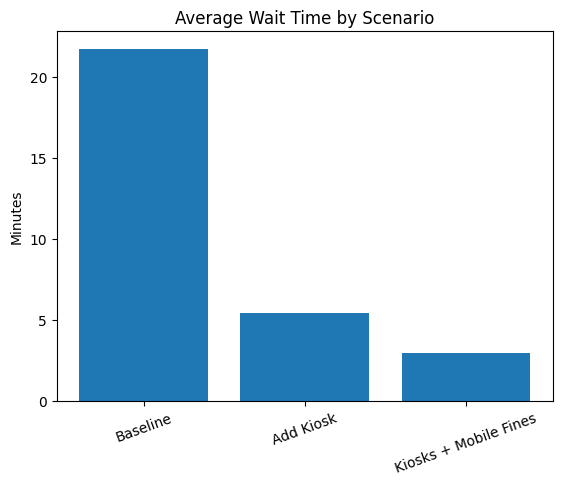

In [7]:
res_df = pd.DataFrame(results)

plt.bar(res_df["Scenario"], res_df["Avg Wait (min)"])
plt.title("Average Wait Time by Scenario")
plt.ylabel("Minutes")
plt.xticks(rotation=20)
plt.show()
